<a href="https://colab.research.google.com/github/martinfinis/HelloCodeSchoolProject/blob/master/RNN_Quest_1_Martin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNN_Quest_1: We will implement a pretrained RNN_Model and classify some artwork! After all, this is more fun than looking at welding seems or lung cancer data. 

You can download the data from: 

https://www.kaggle.com/ikarus777/best-artworks-of-all-time?select=artists.csv

Now only select the data in images of the following painters:

- Rembrandt
- Dürer
- Leonardo da Vinci
- Caravaggio 
- de Bongione 

These are required - if you want, you can also add others, like

- Michelangelo 

- Raffael

and even more. Just make sure that they are from sort of the same time and hence have a similar style. It's pretty easy to distinguish a Rembrandt from an Andy Warhol.

After you have done that, put the images into a data structure like in the Live-Coding last week. You can do that with the script from then (altered of course) - or just do it by hand. But please do not split into Train, Validation and Test set by hand. Use sklearn or any other method to randomly sample the images of each folder into the three sets. 




In [1]:
import keras,os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,BatchNormalization,MaxPooling2D,Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [2]:
import glob
import cv2
import keras,os
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,BatchNormalization,AveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import numpy as np
import pandas as pd

# helper

In [3]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd

def plot_confusion_matrix_x(labels,predictions,classes_name):
  """
  example:
  predictions=max_predict # np.argmax(y_predict, axis=-1)
  labels=test_generator.classes
  classes_name = artist_list
  """
  con_mat = tf.math.confusion_matrix(labels=labels, predictions=np.argmax(predictions, axis=-1) ).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,index = classes_name,columns = classes_name)

  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [4]:
import matplotlib.pyplot as plt

def history_plot_from_loss_acc(history, title):
  plt.figure(figsize=(10,5))

  train_loss_list = history.history['loss']
  train_accuracy = history.history['accuracy']
  val_loss_list = history.history['val_loss']
  val_accuracy_list = history.history['val_accuracy']
  x = history.epoch
  
  plt.subplot(1,2,1)
  plt.plot(x, train_loss_list)
  plt.plot(x, val_loss_list)
  plt.legend(['train_loss', 'val_loss'])
  plt.title(title+"_ LOSS")
  
  plt.subplot(1,2,2)
  plt.plot(x, train_accuracy)
  plt.plot(x, val_accuracy_list)
  plt.legend(['train_acc','val_accuracy'])
  plt.title(title+"_ ACCURACY")
  plt.show()

In [5]:
def create_result_df(y_predict,test_generator):
  """
  y_predict_vgg16 = y_predict
  test_generator = generator
  sub_path = 'test

  uses function:
  get_image_information(main_target_path=main_target_path,
            sub_path='test',
            class_list=artist_list,
            data_format=data_format)

  """
  y_predict = np.argmax(y_predict, axis=-1)
  pre_file_df = pd.DataFrame(data=[y_predict,test_generator.filenames]).T
  pre_file_df.columns = ['predict','class_name']

  df_test =get_image_information(main_target_path=main_target_path,sub_path='test',class_list=artist_list,data_format=data_format)
  df_test['class_name']=df_test.apply(lambda x: (str(x.class_x)+"/"+str(x.name_x)),axis=1)
  df_test = pd.merge(df_test, pre_file_df, on=["class_name", "class_name"])
  df_test['class_value'] = df_test.class_x.map(artist_class_name_dict)
  df_test['test_result'] = df_test.apply(lambda x: x.predict == x.class_value,axis = 1)

  df_groups = df_test.groupby('class_x').agg( class_sum =('class_x','count'),test_sum =('test_result','sum')).reset_index()
  df_groups['percent_all'] = (df_groups['class_sum']/df_groups['class_sum'].sum())*100
  df_groups['percent_test'] = (df_groups['test_sum']/df_groups['class_sum'])*100
  return df_groups



In [6]:
# mount google drive to access dataset food
from google.colab import drive
drive.mount('/content/drive')
# change directory
%cd /content/
# create new local directory, i.e. on the current machine which you are connected to
!mkdir local_data   # could also be another name than local_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [7]:
#/content/drive/MyDrive/Copy_Material_AIDA_2021/Specialization_ML3/Week_3/resized.zip
!unzip '/content/drive/MyDrive/Copy_Material_AIDA_2021/_spec_ML3_wolfgang/Week_3/resized.zip' -d local_data

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
 extracting: local_data/resized/Henri_Matisse_78.jpg  
  inflating: local_data/resized/Henri_Matisse_79.jpg  
  inflating: local_data/resized/Henri_Matisse_8.jpg  
  inflating: local_data/resized/Henri_Matisse_80.jpg  
  inflating: local_data/resized/Henri_Matisse_81.jpg  
  inflating: local_data/resized/Henri_Matisse_82.jpg  
  inflating: local_data/resized/Henri_Matisse_83.jpg  
  inflating: local_data/resized/Henri_Matisse_84.jpg  
  inflating: local_data/resized/Henri_Matisse_85.jpg  
  inflating: local_data/resized/Henri_Matisse_86.jpg  
  inflating: local_data/resized/Henri_Matisse_87.jpg  
  inflating: local_data/resized/Henri_Matisse_88.jpg  
 extracting: local_data/resized/Henri_Matisse_89.jpg  
  inflating: local_data/resized/Henri_Matisse_9.jpg  
  inflating: local_data/resized/Henri_Matisse_90.jpg  
  inflating: local_data/resized/Henri_Matisse_91.jpg  
  inflating: local_data/resized/Henri_Matisse_92.jpg  


In [8]:
cd /content/

/content


In [9]:
#!mkdir training_set
#!mkdir test_set

In [10]:
#ls -l

In [11]:
#rm -r ./best_model_simple/

In [12]:
#/content/local_data/resized
#data_path = 'C:/_dev/_aida/scientificProject/data/w_3/resized'
data_path = '/content/local_data/resized'

#/content/local_data/
#main_target_path = 'C:\\_dev\\_aida\\scientificProject\\data\\w_3\\'
main_target_path = '/content/local_data'


all_subdir = 'data_set'
train_subdir = 'train'
val_subdir = 'valid'
test_subdir = 'test'

train_size = 0.7
val_size = 0.15
test_size = 0.15

artist_list = ['Albrecht_Duerer','Caravaggio','Giotto_di_Bondone','Leonardo_da_Vinci','Michelangelo','Raphael','Rembrandt']
data_format = '/*.jpg'


In [13]:
artist_name_class_dict = { i : artist_list[i] for i in range(0, len(artist_list) ) }
artist_class_name_dict = { artist_list[i] : i for i in range(0, len(artist_list) ) }

In [14]:
artist_class_name_dict

{'Albrecht_Duerer': 0,
 'Caravaggio': 1,
 'Giotto_di_Bondone': 2,
 'Leonardo_da_Vinci': 3,
 'Michelangelo': 4,
 'Raphael': 5,
 'Rembrandt': 6}

# import and organize images

In [15]:
for file_name in listdir(data_path):
    #print(file_name)

    #convert Albrecht_DuÔòá├¬rer
    if file_name.startswith('Albrecht_DuтХа├кrer'):
        new_file_name = file_name.replace('Albrecht_DuтХа├кrer','Albrecht_Duerer_x')
    elif file_name.startswith('Albrecht_Du╠Иrer'):
        new_file_name = file_name.replace('Albrecht_Du╠Иrer','Albrecht_Duerer_y')
    else:
        new_file_name = file_name

    for artist_name in artist_list:
        if new_file_name.startswith(artist_name):
            filepath = os.path.join(data_path,file_name)
            new_filepath = os.path.join(main_target_path,all_subdir,artist_name,new_file_name)

            #check dir and create
            if not os.path.exists(os.path.join(main_target_path,all_subdir,artist_name)):
                os.makedirs(os.path.join(main_target_path,all_subdir,artist_name))
            #move file
            try:
                os.rename(filepath, new_filepath)
            except:
                continue

In [16]:
import glob
data_format = '/*.jpg'

def number_of_images_in_path(target_path,data_format):
    print(target_path)
    img_path_list = glob.glob(target_path + data_format)
           
    n = len(img_path_list)
    print(f'Number of images: {n}\n')

for artist_name in artist_list:
    number_of_images_in_path(os.path.join(os.sep,main_target_path,all_subdir,artist_name),data_format)

/content/local_data/data_set/Albrecht_Duerer
Number of images: 656

/content/local_data/data_set/Caravaggio
Number of images: 55

/content/local_data/data_set/Giotto_di_Bondone
Number of images: 119

/content/local_data/data_set/Leonardo_da_Vinci
Number of images: 143

/content/local_data/data_set/Michelangelo
Number of images: 49

/content/local_data/data_set/Raphael
Number of images: 109

/content/local_data/data_set/Rembrandt
Number of images: 262



Now explore the data. 

- What are the different image dimensions?

- How are the labels distributed?

- What else would be useful to know?

In [17]:
def get_image_information(main_target_path,sub_path ,class_list ,data_format ):
    info_array = []#np.array([[0,8]])
    column_names = ['class_x','name_x','row','column','channel','shape','main_target_path','sub_path']

    for class_name in class_list:
        path = os.path.join(os.sep,main_target_path,sub_path,class_name)
        img_path_list = glob.glob(path + data_format)

        for img_path in img_path_list:
            img = cv2.imread(img_path)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            info_array.append([class_name,os.path.split(img_path)[-1],img.shape[0],img.shape[1],img.shape[2],img.shape,main_target_path,sub_path])

    df = pd.DataFrame(data=info_array,columns= column_names)
    return df

df =get_image_information(main_target_path=main_target_path,sub_path=all_subdir,class_list=artist_list,data_format=data_format)
df

,class_x,name_x,row,column,channel,shape,main_target_path,sub_path
0,Albrecht_Duerer,Albrecht_Duerer_y_230.jpg,1229,893,3,"(1229, 893, 3)",/content/local_data,data_set
1,Albrecht_Duerer,Albrecht_Duerer_y_88.jpg,1229,835,3,"(1229, 835, 3)",/content/local_data,data_set
2,Albrecht_Duerer,Albrecht_Duerer_x_166.jpg,614,598,3,"(614, 598, 3)",/content/local_data,data_set
3,Albrecht_Duerer,Albrecht_Duerer_y_268.jpg,614,442,3,"(614, 442, 3)",/content/local_data,data_set
4,Albrecht_Duerer,Albrecht_Duerer_y_74.jpg,1229,1080,3,"(1229, 1080, 3)",/content/local_data,data_set
...,...,...,...,...,...,...,...,...
1388,Rembrandt,Rembrandt_228.jpg,540,437,3,"(540, 437, 3)",/content/local_data,data_set
1389,Rembrandt,Rembrandt_188.jpg,663,886,3,"(663, 886, 3)",/content/local_data,data_set
1390,Rembrandt,Rembrandt_23.jpg,614,518,3,"(614, 518, 3)",/content/local_data,data_set
1391,Rembrandt,Rembrandt_61.jpg,614,509,3,"(614, 509, 3)",/content/local_data,data_set


In [18]:
df['size'] = df.apply(lambda x: x.row*x.column,axis=1)

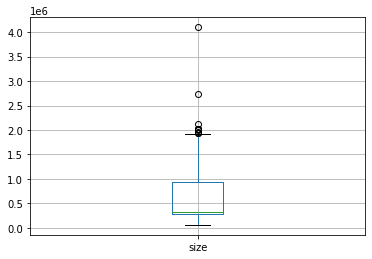

In [19]:
df[['size']].boxplot()

In [20]:
df['size'].quantile([0.25,0.5,0.75,1])

0.25     276300.0
0.50     332353.0
0.75     934040.0
1.00    4100656.0
Name: size, dtype: float64

In [21]:
df['size'].describe()

count    1.393000e+03
mean     5.760644e+05
std      4.470891e+05
min      6.030000e+04
25%      2.763000e+05
50%      3.323530e+05
75%      9.340400e+05
max      4.100656e+06
Name: size, dtype: float64

In [22]:
df_group = df.groupby('class_x').agg(img_count=('class_x','count'),size_mean=('size','mean'),size_min=('size','min'),size_max=('size','max')).reset_index()

In [23]:
import math
df_group['size_mean_sqrt'] = df_group['size_mean'].apply(lambda x: math.sqrt(x))

In [24]:
df_group

,class_x,img_count,size_mean,size_min,size_max,size_mean_sqrt
0,Albrecht_Duerer,656,736346.371951,93240,1866851,858.106271
1,Caravaggio,55,872363.345455,158760,2028594,934.003932
2,Giotto_di_Bondone,119,312735.689076,157700,373240,559.227761
3,Leonardo_da_Vinci,143,365021.181818,60300,1574195,604.169829
4,Michelangelo,49,630654.448980,251126,1369256,794.137550
5,Raphael,109,283307.486239,106836,376996,532.266368
6,Rembrandt,262,458924.843511,97560,4100656,677.439919


In [25]:
df.groupby('class_x').agg(row_min=('row','min'),row_max=('row','max'),row_maen=('row','mean'),column_min=('column','min'),column_man=('column','max'),column_mean=('column','mean'))

,row_min,row_max,row_maen,column_min,column_man,column_mean
class_x,,,,,,
Albrecht_Duerer,239,1229,899.481707,241,1536,736.542683
Caravaggio,417,1671,922.890909,270,1214,841.581818
Giotto_di_Bondone,360,778,587.344538,360,756,540.495798
Leonardo_da_Vinci,232,1604,645.195804,201,1097,533.811189
Michelangelo,410,1378,768.061224,409,1148,774.020408
Raphael,174,614,589.724771,354,614,485.688073
Rembrandt,360,2296,691.984733,271,1786,606.858779


## orginze in train,test and validate

In [26]:
all_subdir = 'data_set'
train_subdir = 'train'
val_subdir = 'validation'
test_subdir = 'test'

train_size = 0.7
val_size = 0.15
test_size = 0.15

def number_of_images_in_path(target_path,data_format):
    print(target_path)
    img_path_list = glob.glob(target_path + data_format)

    n = len(img_path_list)
    print(f'Number of images: {n}\n')
    return img_path_list

def organize_train_test_vaildation_dir(main_target_path,all_subdir,class_list,data_format,ml_subdir_list,train_size,test_size,validation_size):
    """
    :param main_target_path:
    :param all_subdir:
    :param class_list:
    :param data_format:
    :param ml_subdir_list:
    :param train_size:
    :param test_size:
    :param validation_size:
    :return:
    """
    assert(train_size+test_size+validation_size == 1)

    for ml_subdir in ml_subdir_list:
        if not os.path.exists(os.path.join(main_target_path, ml_subdir)):
            os.makedirs(os.path.join(main_target_path, ml_subdir))

    for class_name in class_list:
        img_path_list =  number_of_images_in_path(os.path.join(os.sep,main_target_path,all_subdir,class_name),data_format)

        #shuffle
        np.random.shuffle(img_path_list)
        #create class_dir
        for ml_subdir in ml_subdir_list:
            if not os.path.exists(os.path.join(main_target_path,ml_subdir,class_name)):
                os.makedirs(os.path.join(main_target_path,ml_subdir,class_name))

        #move images to class subdir
        train_stop = int(len(img_path_list) * train_size)
        validation_stop = train_stop + int(len(img_path_list) * validation_size)
        test_stop = validation_stop + int(len(img_path_list) * test_size)

        n = 0
        for imp_path in img_path_list:
            new_filepath = ''
            if n <= train_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[0], class_name, os.path.split(img_path_list[n])[-1])
            elif n <= validation_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[1], class_name, os.path.split(img_path_list[n])[-1])
            elif n <= test_stop:
                new_filepath = os.path.join(main_target_path, ml_subdir_list[2], class_name, os.path.split(img_path_list[n])[-1])

            # move file
            try:
                os.rename(img_path_list[n], new_filepath)
                n += 1
            except:
                continue


organize_train_test_vaildation_dir(main_target_path=main_target_path,all_subdir=all_subdir,
                                   class_list=artist_list,data_format=data_format,
                                   ml_subdir_list=[train_subdir,val_subdir,test_subdir],
                                   train_size=train_size,
                                   validation_size=val_size,
                                   test_size=test_size)

/content/local_data/data_set/Albrecht_Duerer
Number of images: 656

/content/local_data/data_set/Caravaggio
Number of images: 55

/content/local_data/data_set/Giotto_di_Bondone
Number of images: 119

/content/local_data/data_set/Leonardo_da_Vinci
Number of images: 143

/content/local_data/data_set/Michelangelo
Number of images: 49

/content/local_data/data_set/Raphael
Number of images: 109

/content/local_data/data_set/Rembrandt
Number of images: 262



What is the most obvious way to deal with this data?

Think a bit about it. 

Correct: We just resize all images to the same size! In this case to a dimension which can easily be used in a Resnet50 or a VGG_16 or VGG_19, i.e. 224 x 224 You do not have to code this here, as the data generator will do it for us (at least if you use the same one as last week). 

Now set up the data generator - and test it. 


In [27]:
train_gen = ImageDataGenerator(rescale=1./255.)
validation_gen = ImageDataGenerator(rescale=1./255.)
test_gen = ImageDataGenerator(rescale=1./255.)

In [28]:
train_generator = train_gen.flow_from_directory(directory="/content/local_data/train",target_size=(224,224),batch_size=16,shuffle=True,seed=42)
valid_generator = validation_gen.flow_from_directory(directory="/content/local_data/validation",target_size=(224,224),batch_size=16,shuffle=False,seed=42)
test_generator = test_gen.flow_from_directory(directory="/content/local_data/test", target_size=(224,224),batch_size=16,shuffle=False,seed=42)

Found 980 images belonging to 7 classes.
Found 206 images belonging to 7 classes.
Found 206 images belonging to 7 classes.


Now set up a Resnet50 and a VGG_19 (or another model for comparison), pretrained on Imagenet - and write a new custom top-layer to match the number of classes you've chosen. 

# simple model for baseline

In [29]:
in_shape = (224,224,3)

In [30]:
learning_rate = 0.0001
dec_rate = 0 #1/4353 * 0.2 
optim = Adam(lr=learning_rate, decay=dec_rate)

model = Sequential()
model.add(Conv2D(32, (3,3), padding='valid',activation='relu', input_shape=in_shape))
model.add(MaxPooling2D())
model.add(Conv2D(64,(3,3), padding='valid',activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128,(3,3), padding='valid',activation='relu'))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(7,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 346112)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [31]:
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy') 

In [32]:
mcp_1 = ModelCheckpoint('best_model_simple', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto', restore_best_weights=True)

In [33]:
history_model = model.fit(train_generator,validation_data = valid_generator,epochs=10,callbacks=[mcp_1,early])    

Epoch 1/10
62/62 [==============================] - 13s 157ms/step - loss: 1.5032 - accuracy: 0.4791 - val_loss: 0.9071 - val_accuracy: 0.7136

Epoch 00001: val_accuracy improved from -inf to 0.71359, saving model to best_model_simple
INFO:tensorflow:Assets written to: best_model_simple/assets
Epoch 2/10
62/62 [==============================] - 9s 144ms/step - loss: 0.8809 - accuracy: 0.6839 - val_loss: 0.7776 - val_accuracy: 0.7767

Epoch 00002: val_accuracy improved from 0.71359 to 0.77670, saving model to best_model_simple
INFO:tensorflow:Assets written to: best_model_simple/assets
Epoch 3/10
62/62 [==============================] - 9s 145ms/step - loss: 0.7272 - accuracy: 0.7524 - val_loss: 0.6410 - val_accuracy: 0.8252

Epoch 00003: val_accuracy improved from 0.77670 to 0.82524, saving model to best_model_simple
INFO:tensorflow:Assets written to: best_model_simple/assets
Epoch 4/10
62/62 [==============================] - 9s 146ms/step - loss: 0.4937 - accuracy: 0.8507 - val_loss:

## results

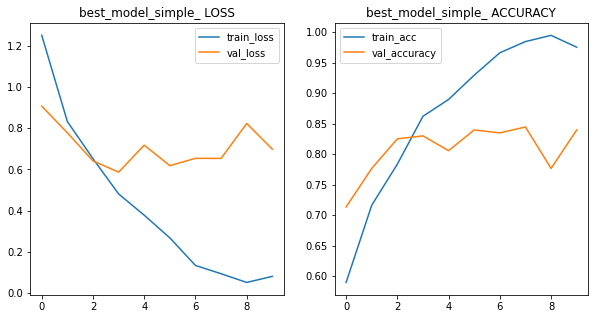

In [34]:
history_plot_from_loss_acc(history_model,'best_model_simple')

In [35]:
best_simple_model = load_model('best_model_simple')
best_simple_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 346112)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [36]:
best_simple_model.evaluate(test_generator)

13/13 [==============================] - 2s 115ms/step - loss: 0.5435 - accuracy: 0.8350


[0.543523371219635, 0.8349514603614807]

In [37]:
y_predict_simple_model = best_simple_model.predict(test_generator)

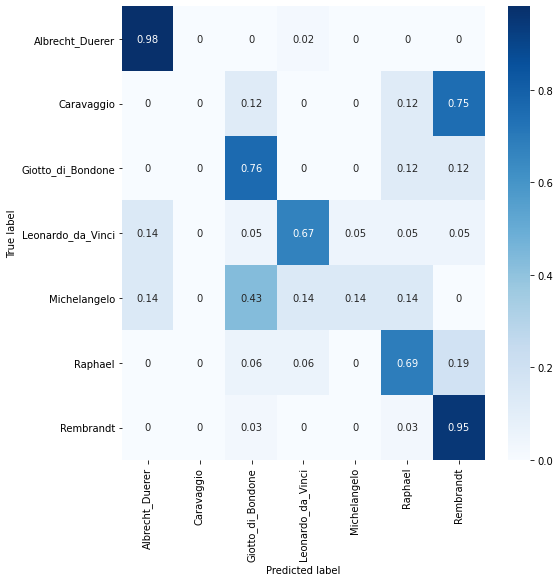

In [38]:
plot_confusion_matrix_x(test_generator.classes,y_predict_simple_model,artist_list)

In [39]:
create_result_df(y_predict_simple_model,test_generator)

,class_x,class_sum,test_sum,percent_all,percent_test
0,Albrecht_Duerer,98,96,47.572816,97.959184
1,Caravaggio,8,0,3.883495,0.000000
2,Giotto_di_Bondone,17,13,8.252427,76.470588
3,Leonardo_da_Vinci,21,14,10.194175,66.666667
4,Michelangelo,7,1,3.398058,14.285714
5,Raphael,16,11,7.766990,68.750000
6,Rembrandt,39,37,18.932039,94.871795


# VGG16 from Keras

Build a convolutional neural network based on the [VGG16](https://neurohive.io/en/popular-networks/vgg16/) architecture.

In [40]:
import tensorflow. keras as keras
vgg16_model = keras.applications.VGG16()

In [41]:
vgg16_model = keras.applications.vgg16.VGG16(
  weights='imagenet',
  include_top=False,
  input_shape=in_shape)

In [42]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [43]:
model_vgg16_c = Sequential()
for layer in vgg16_model.layers:
  model_vgg16_c.add(layer)

In [44]:
for layer in model_vgg16_c.layers:
  layer.trainable = False

In [45]:
model_vgg16_c.add(Flatten())
model_vgg16_c.add(Dense(256,activation='relu'))
model_vgg16_c.add(Dropout(0.5))
model_vgg16_c.add(Dense(7,activation='softmax'))
model_vgg16_c.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [46]:
model_vgg16_c.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy') 

In [47]:
mcp_2 = ModelCheckpoint('keras_applications_VGG16', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [48]:
history_model_vgg16_c = model_vgg16_c.fit(train_generator,validation_data = valid_generator,epochs=15,callbacks=[mcp_2,early])    

Epoch 1/15
62/62 [==============================] - 18s 226ms/step - loss: 1.3991 - accuracy: 0.5334 - val_loss: 0.5584 - val_accuracy: 0.8204

Epoch 00001: val_accuracy improved from -inf to 0.82039, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 2/15
62/62 [==============================] - 10s 155ms/step - loss: 0.6038 - accuracy: 0.7981 - val_loss: 0.4497 - val_accuracy: 0.8447

Epoch 00002: val_accuracy improved from 0.82039 to 0.84466, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 3/15
62/62 [==============================] - 10s 157ms/step - loss: 0.4014 - accuracy: 0.8685 - val_loss: 0.3865 - val_accuracy: 0.8738

Epoch 00003: val_accuracy improved from 0.84466 to 0.87379, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 4/15
62/62 [==============================] - 10s 156ms/step 

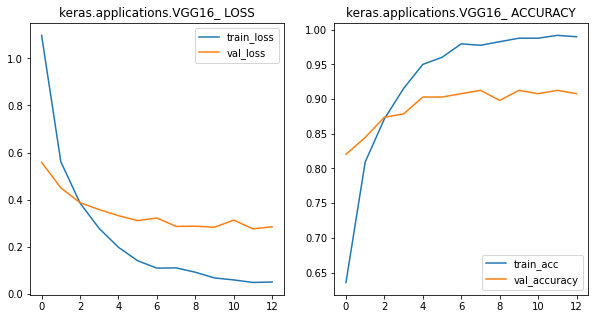

In [49]:
history_plot_from_loss_acc(history_model_vgg16_c,'keras.applications.VGG16')

In [50]:
best_keras_applications_VGG16_model = load_model('keras_applications_VGG16')

#### result

In [51]:
y_eval = best_keras_applications_VGG16_model.evaluate(test_generator)

13/13 [==============================] - 2s 128ms/step - loss: 0.3204 - accuracy: 0.8786


In [52]:
y_predict_vgg16_model = best_keras_applications_VGG16_model.predict(test_generator)

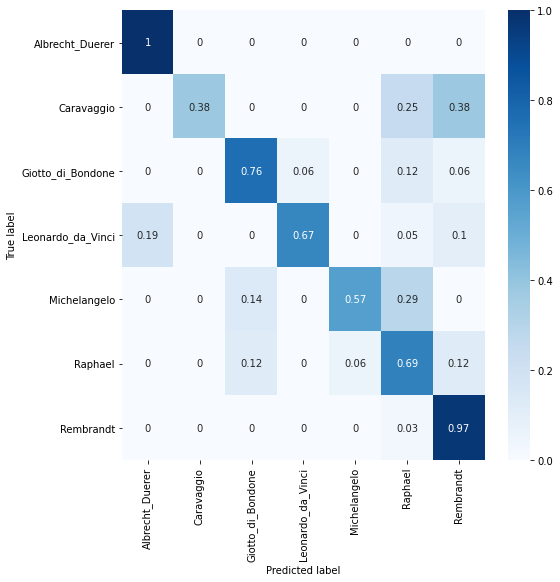

In [53]:
plot_confusion_matrix_x(test_generator.classes,y_predict_vgg16_model,artist_list)

In [54]:
create_result_df(y_predict_vgg16_model,test_generator)

,class_x,class_sum,test_sum,percent_all,percent_test
0,Albrecht_Duerer,98,98,47.572816,100.000000
1,Caravaggio,8,3,3.883495,37.500000
2,Giotto_di_Bondone,17,13,8.252427,76.470588
3,Leonardo_da_Vinci,21,14,10.194175,66.666667
4,Michelangelo,7,4,3.398058,57.142857
5,Raphael,16,11,7.766990,68.750000
6,Rembrandt,39,38,18.932039,97.435897


In [55]:
test_generator.filenames[:5]

['Albrecht_Duerer/Albrecht_Duerer_x_102.jpg',
 'Albrecht_Duerer/Albrecht_Duerer_x_120.jpg',
 'Albrecht_Duerer/Albrecht_Duerer_x_128.jpg',
 'Albrecht_Duerer/Albrecht_Duerer_x_142.jpg',
 'Albrecht_Duerer/Albrecht_Duerer_x_144.jpg']

# resnet50

### top model

In [56]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, Input, AveragePooling2D, Conv2D
from keras import initializers
from keras.callbacks import Callback
import tensorflow as tf
from keras.applications.resnet50 import ResNet50

In [57]:
resnet50 = ResNet50(include_top=False, input_shape=in_shape)
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [58]:
dropout_rate = 0.3
num_classes = 7

# Top Model
a = Input(shape=(7,7,2048))
#x = AveragePooling2D(7,7)(name='avg_pool_1')(a)
x = AveragePooling2D(7,7)(a)
x = Flatten()(x)
x = Dropout(dropout_rate)(x)
x = Dense(2048, kernel_initializer=initializers.he_normal(), bias_initializer=initializers.ones(),activation='relu')(x)
x = Dense(num_classes, kernel_initializer=initializers.he_normal(), bias_initializer=initializers.ones(), activation='softmax')(x)
top_model = Model(inputs=a, outputs=x)

top_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 7, 7, 2048)]      0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 14343     
Total params: 4,210,695
Trainable params: 4,210,695
Non-trainable params: 0
___________________________________________________

In [59]:
inp = Input(shape=in_shape)
y = resnet50(inp)
y = top_model(y)
final_model = Model(inp,y)

final_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
model (Functional)           (None, 7)                 4210695   
Total params: 27,798,407
Trainable params: 27,745,287
Non-trainable params: 53,120
_________________________________________________________________


In [60]:
final_model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy') 

In [61]:
mcp_3 = ModelCheckpoint('final_model_resnet_1', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [105]:
history_model_final_model = final_model.fit(train_generator,validation_data = valid_generator,epochs=25,callbacks=[mcp_3])    

Epoch 1/25
62/62 [==============================] - 23s 372ms/step - loss: 0.2559 - accuracy: 0.9184 - val_loss: 4.5198 - val_accuracy: 0.4757

Epoch 00001: val_accuracy did not improve from 0.47573
Epoch 2/25
62/62 [==============================] - 23s 374ms/step - loss: 0.2597 - accuracy: 0.9184 - val_loss: 6.2379 - val_accuracy: 0.4709

Epoch 00002: val_accuracy did not improve from 0.47573
Epoch 3/25
62/62 [==============================] - 23s 372ms/step - loss: 0.2003 - accuracy: 0.9224 - val_loss: 5.3462 - val_accuracy: 0.4612

Epoch 00003: val_accuracy did not improve from 0.47573
Epoch 4/25
62/62 [==============================] - 23s 370ms/step - loss: 0.1821 - accuracy: 0.9469 - val_loss: 4.5570 - val_accuracy: 0.4854

Epoch 00004: val_accuracy improved from 0.47573 to 0.48544, saving model to final_model_resnet_1
INFO:tensorflow:Assets written to: final_model_resnet_1/assets
Epoch 5/25
62/62 [==============================] - 23s 370ms/step - loss: 0.1757 - accuracy: 0.940

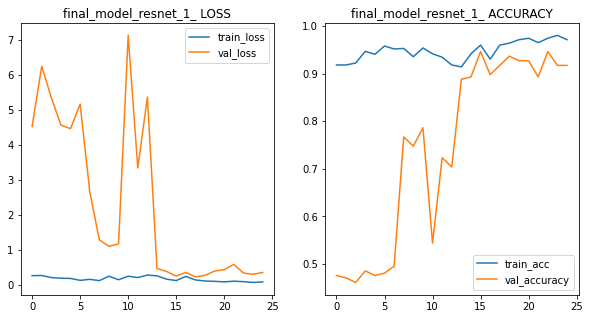

In [106]:
history_plot_from_loss_acc(history_model_final_model,'final_model_resnet_1')

In [107]:
best_final_model_resnet = load_model('final_model_resnet_1')#final_model

### result

In [108]:
best_final_model_resnet.evaluate(test_generator)

13/13 [==============================] - 3s 131ms/step - loss: 0.3253 - accuracy: 0.9126


[0.32534804940223694, 0.9126213788986206]

In [109]:
y_predict_resnet_model = best_final_model_resnet.predict(test_generator)

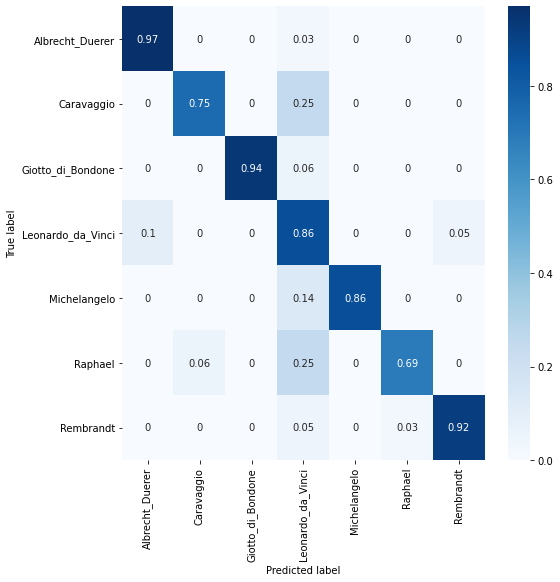

In [110]:
plot_confusion_matrix_x(test_generator.classes,y_predict_resnet_model,artist_list)

In [111]:
create_result_df(y_predict_resnet_model,test_generator)

,class_x,class_sum,test_sum,percent_all,percent_test
0,Albrecht_Duerer,98,95,47.572816,96.938776
1,Caravaggio,8,6,3.883495,75.000000
2,Giotto_di_Bondone,17,16,8.252427,94.117647
3,Leonardo_da_Vinci,21,18,10.194175,85.714286
4,Michelangelo,7,6,3.398058,85.714286
5,Raphael,16,11,7.766990,68.750000
6,Rembrandt,39,36,18.932039,92.307692


#### view

/content/local_data/test/Albrecht_Duerer/Albrecht_Duerer_y_171.jpg
[[9.4368631e-01 8.8568684e-04 9.7042398e-04 1.7226719e-06 1.1286816e-05
  3.5157092e-02 1.9287383e-02]]
None


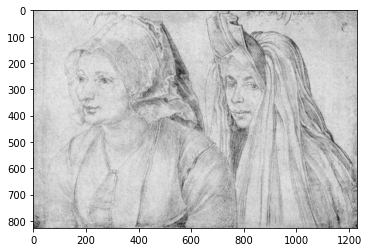

/content/local_data/test/Caravaggio/Caravaggio_19.jpg
[[9.4646251e-01 8.4628136e-04 1.0871008e-03 2.1892977e-06 8.3274190e-06
  2.9308898e-02 2.2284640e-02]]
None


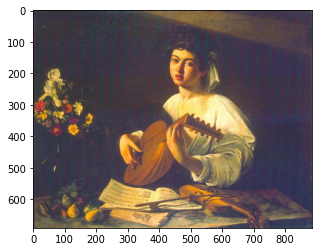

/content/local_data/test/Giotto_di_Bondone/Giotto_di_Bondone_44.jpg
[[9.5549393e-01 1.0854929e-03 1.4421508e-03 1.9672266e-06 7.9820138e-06
  1.4948027e-02 2.7020507e-02]]
None


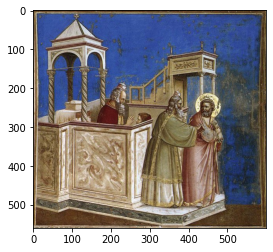

/content/local_data/test/Leonardo_da_Vinci/Leonardo_da_Vinci_115.jpg
[[9.1531336e-01 6.4766617e-04 1.3366246e-03 1.9056454e-06 1.1353184e-05
  6.5150425e-02 1.7538695e-02]]
None


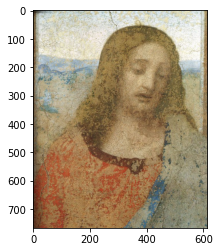

/content/local_data/test/Michelangelo/Michelangelo_5.jpg
[[9.5678264e-01 9.0634264e-04 1.1872466e-03 1.7811324e-06 1.0434019e-05
  2.5337437e-02 1.5774174e-02]]
None


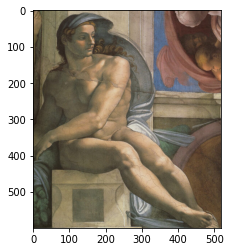

/content/local_data/test/Raphael/Raphael_6.jpg
[[9.5759040e-01 1.1600144e-03 9.3271805e-04 1.8897214e-06 7.5247503e-06
  1.4160118e-02 2.6147377e-02]]
None


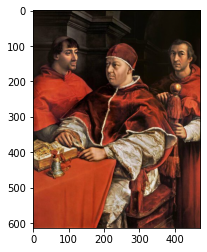

/content/local_data/test/Rembrandt/Rembrandt_253.jpg
[[9.2886841e-01 6.9004268e-04 1.2820137e-03 1.8858178e-06 9.4612460e-06
  5.1652197e-02 1.7495932e-02]]
None


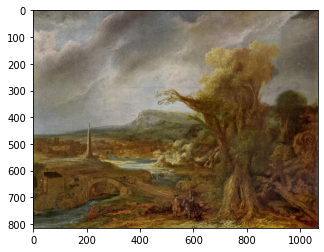

In [69]:
for art in artist_list:
  img_path = os.path.join(main_target_path,test_subdir,art)
  # Paths and Variables
  img_file_list=os.listdir(img_path)
  img_file=np.random.choice(img_file_list)
  
  img_rdn=cv2.imread(os.path.join(os.sep,img_path,img_file))
  img_rdn_cvt = cv2.cvtColor(img_rdn, cv2.COLOR_BGR2RGB)
  
  img_rdn_cvt = img_rdn_cvt/255
  img_rdn_rs = cv2.resize(img_rdn_cvt, (224, 224), interpolation = cv2.INTER_AREA)
  
  test_predict = best_final_model_resnet.predict(np.expand_dims(img_rdn_rs, axis=0))
  max_predict = np.argmax(test_predict, axis=-1)

  print(os.path.join(os.sep,img_path,img_file))
  print(test_predict)
  print(artist_class_name_dict.get(max_predict[0]))

  plt.imshow(img_rdn_cvt)
  plt.show()

# Compare both models

Compare both models - which has more parameters?

In [70]:
# fgg16  Total params: 21,139,271
# resnet Total params: 27,798,407
# the resnet has more parameters

Compile both models, train both models and evaluate both models on the test set.

In [71]:
# the resnet get with my setup the better results, but it needs more epochs to train

# Data Augmentation

Now try to tune the hyperparameters, including

*   Optimizer
*   Data Augmentation (look at what keras has under the hood)



### Data Augmentation (look at what keras has under the hood)

In [72]:
train_gen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        brightness_range = (0.7, 1.3),
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=359)

In [73]:
train_generator = train_gen.flow_from_directory(directory="/content/local_data/train",target_size=(224,224),batch_size=16,shuffle=True,seed=42)

Found 980 images belonging to 7 classes.


### simple

In [74]:
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy') 

In [75]:
mcp_4 = ModelCheckpoint('best_model_simple', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [76]:
history_model = model.fit(train_generator,validation_data = valid_generator,epochs=20,callbacks=[mcp_4,early])    

Epoch 1/20
62/62 [==============================] - 20s 316ms/step - loss: 1.0355 - accuracy: 0.6877 - val_loss: 0.6095 - val_accuracy: 0.8495

Epoch 00001: val_accuracy improved from -inf to 0.84951, saving model to best_model_simple
INFO:tensorflow:Assets written to: best_model_simple/assets
Epoch 2/20
62/62 [==============================] - 19s 312ms/step - loss: 0.7984 - accuracy: 0.7262 - val_loss: 0.5594 - val_accuracy: 0.8689

Epoch 00002: val_accuracy improved from 0.84951 to 0.86893, saving model to best_model_simple
INFO:tensorflow:Assets written to: best_model_simple/assets
Epoch 3/20
62/62 [==============================] - 19s 313ms/step - loss: 0.7526 - accuracy: 0.7711 - val_loss: 0.7193 - val_accuracy: 0.7961

Epoch 00003: val_accuracy did not improve from 0.86893
Epoch 4/20
62/62 [==============================] - 19s 311ms/step - loss: 0.7568 - accuracy: 0.7475 - val_loss: 0.5603 - val_accuracy: 0.8350

Epoch 00004: val_accuracy did not improve from 0.86893
Epoch 5/2

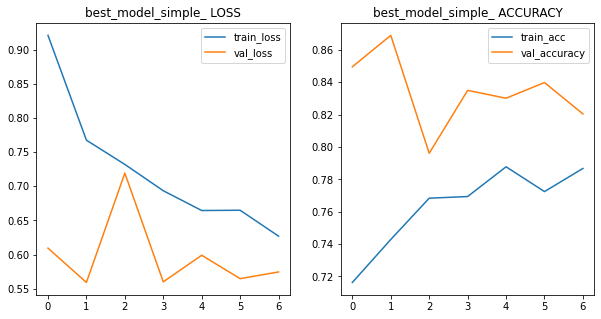

In [77]:
history_plot_from_loss_acc(history_model,'best_model_simple')

In [78]:
best_model_simple = load_model('best_model_simple')
best_model_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 346112)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

#### result

In [79]:
best_model_simple.evaluate(test_generator)

13/13 [==============================] - 2s 116ms/step - loss: 0.5075 - accuracy: 0.8252


[0.5074920058250427, 0.8252426981925964]

In [80]:
y_predict_simple_model = best_simple_model.predict(test_generator)

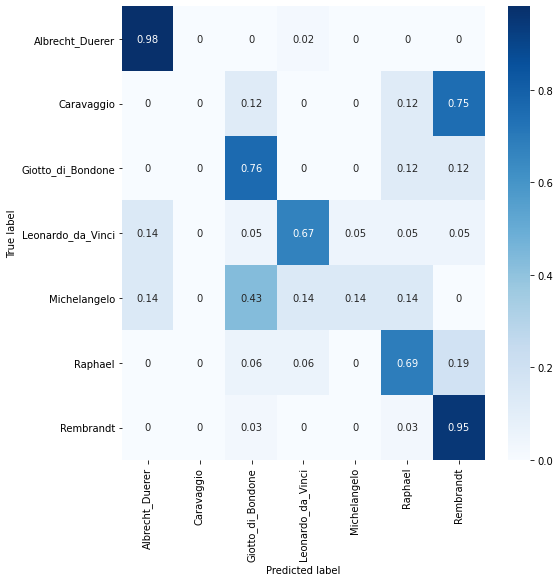

In [81]:
plot_confusion_matrix_x(test_generator.classes,y_predict_simple_model,artist_list)

In [82]:
create_result_df(y_predict_simple_model,test_generator)

,class_x,class_sum,test_sum,percent_all,percent_test
0,Albrecht_Duerer,98,96,47.572816,97.959184
1,Caravaggio,8,0,3.883495,0.000000
2,Giotto_di_Bondone,17,13,8.252427,76.470588
3,Leonardo_da_Vinci,21,14,10.194175,66.666667
4,Michelangelo,7,1,3.398058,14.285714
5,Raphael,16,11,7.766990,68.750000
6,Rembrandt,39,37,18.932039,94.871795


### VGG16

In [83]:
model_vgg16_c.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy') 

In [84]:
mcp_5 = ModelCheckpoint('keras_applications_VGG16', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [85]:
history_model_vgg16_c = model_vgg16_c.fit(train_generator,validation_data = valid_generator,epochs=20,callbacks=[mcp_5])    

Epoch 1/20
62/62 [==============================] - 21s 334ms/step - loss: 0.6908 - accuracy: 0.7763 - val_loss: 0.3577 - val_accuracy: 0.8835

Epoch 00001: val_accuracy improved from -inf to 0.88350, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 2/20
62/62 [==============================] - 21s 332ms/step - loss: 0.5464 - accuracy: 0.8203 - val_loss: 0.3438 - val_accuracy: 0.8932

Epoch 00002: val_accuracy improved from 0.88350 to 0.89320, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 3/20
62/62 [==============================] - 20s 329ms/step - loss: 0.5582 - accuracy: 0.8028 - val_loss: 0.3356 - val_accuracy: 0.9029

Epoch 00003: val_accuracy improved from 0.89320 to 0.90291, saving model to keras_applications_VGG16
INFO:tensorflow:Assets written to: keras_applications_VGG16/assets
Epoch 4/20
62/62 [==============================] - 21s 331ms/step 

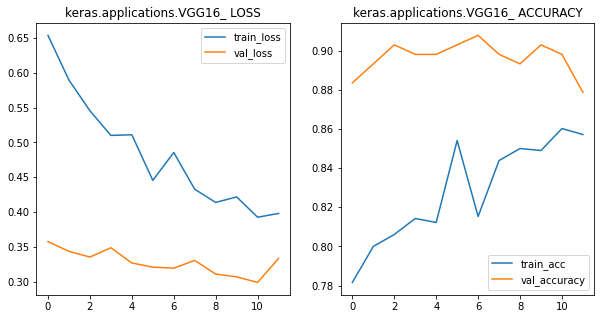

In [86]:
history_plot_from_loss_acc(history_model_vgg16_c,'keras.applications.VGG16')

In [87]:
best_VGG16_model = load_model('keras_applications_VGG16')

In [88]:
best_VGG16_model.evaluate(test_generator)

13/13 [==============================] - 2s 130ms/step - loss: 0.3389 - accuracy: 0.8738


[0.33894792199134827, 0.8737863898277283]

#### result

In [89]:
y_predict_best_VGG16_model = best_VGG16_model.predict(test_generator)

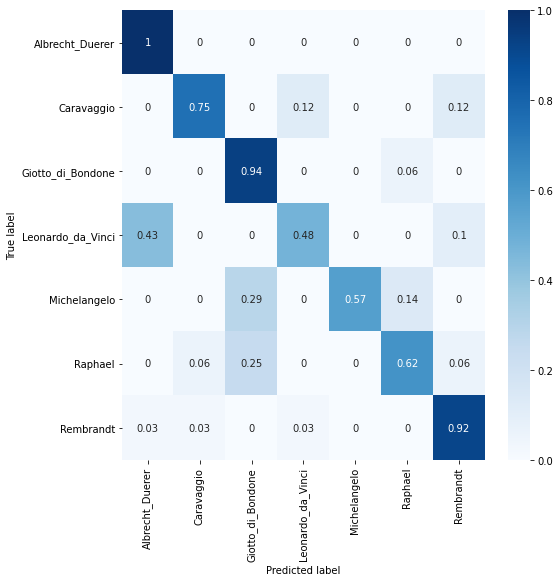

In [90]:
plot_confusion_matrix_x(test_generator.classes,y_predict_best_VGG16_model,artist_list)

In [91]:
create_result_df(y_predict_best_VGG16_model,test_generator)

,class_x,class_sum,test_sum,percent_all,percent_test
0,Albrecht_Duerer,98,98,47.572816,100.000000
1,Caravaggio,8,6,3.883495,75.000000
2,Giotto_di_Bondone,17,16,8.252427,94.117647
3,Leonardo_da_Vinci,21,10,10.194175,47.619048
4,Michelangelo,7,4,3.398058,57.142857
5,Raphael,16,10,7.766990,62.500000
6,Rembrandt,39,36,18.932039,92.307692


### RESNET 50

#### top model

In [112]:
dropout_rate = 0.3
num_classes = 7

# Top Model
a = Input(shape=(7,7,2048))
#x = AveragePooling2D(7,7)(name='avg_pool_1')(a)
x = AveragePooling2D(7,7)(a)
x = Flatten()(x)
x = Dropout(dropout_rate)(x)
x = Dense(2048, kernel_initializer=initializers.he_normal(), bias_initializer=initializers.ones(),activation='relu')(x)
x = Dense(num_classes, kernel_initializer=initializers.he_normal(), bias_initializer=initializers.ones(), activation='softmax')(x)
top_model = Model(inputs=a, outputs=x)

top_model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 7, 7, 2048)]      0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 14343     
Total params: 4,210,695
Trainable params: 4,210,695
Non-trainable params: 0
_________________________________________________

In [113]:
inp = Input(shape=in_shape)
y = resnet50(inp)
y = top_model(y)
final_model_resnet = Model(inp,y)

final_model_resnet.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
model_4 (Functional)         (None, 7)                 4210695   
Total params: 27,798,407
Trainable params: 27,745,287
Non-trainable params: 53,120
_________________________________________________________________


In [114]:
final_model_resnet.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics='accuracy') 

In [115]:
mcp_6 = ModelCheckpoint('final_model_resnet', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [116]:
history_final_model_resnet = final_model.fit(train_generator,validation_data = valid_generator,epochs=25,callbacks=[mcp_6])    

Epoch 1/25
62/62 [==============================] - 23s 375ms/step - loss: 0.0528 - accuracy: 0.9816 - val_loss: 0.3665 - val_accuracy: 0.9369

Epoch 00001: val_accuracy improved from -inf to 0.93689, saving model to final_model_resnet
INFO:tensorflow:Assets written to: final_model_resnet/assets
Epoch 2/25
62/62 [==============================] - 23s 372ms/step - loss: 0.0784 - accuracy: 0.9776 - val_loss: 1.3721 - val_accuracy: 0.8252

Epoch 00002: val_accuracy did not improve from 0.93689
Epoch 3/25
62/62 [==============================] - 23s 373ms/step - loss: 0.0730 - accuracy: 0.9796 - val_loss: 0.5152 - val_accuracy: 0.9029

Epoch 00003: val_accuracy did not improve from 0.93689
Epoch 4/25
62/62 [==============================] - 23s 373ms/step - loss: 0.0565 - accuracy: 0.9755 - val_loss: 0.3729 - val_accuracy: 0.9320

Epoch 00004: val_accuracy did not improve from 0.93689
Epoch 5/25
62/62 [==============================] - 23s 374ms/step - loss: 0.0512 - accuracy: 0.9837 - val

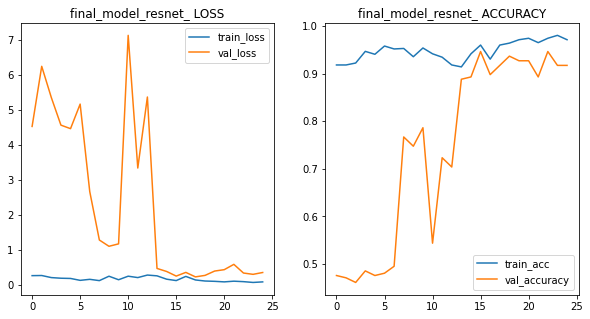

In [117]:
history_plot_from_loss_acc(history_model_final_model,'final_model_resnet')

In [118]:
best_final_model = load_model('final_model_resnet')

#### result

In [119]:
best_final_model.evaluate(test_generator)

13/13 [==============================] - 4s 134ms/step - loss: 0.3948 - accuracy: 0.9320


[0.39479511976242065, 0.9320388436317444]

In [120]:
y_predict_resnet_au = best_final_model.predict(test_generator)

In [101]:
#y_predict_resnet_au = np.argmax(y_predict_resnet_au, axis=-1)

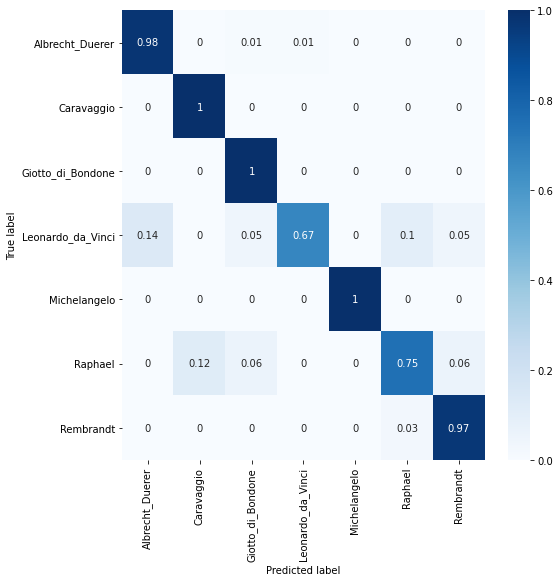

In [121]:
plot_confusion_matrix_x(test_generator.classes,y_predict_resnet_au,artist_list)

In [122]:
create_result_df(y_predict_resnet_au,test_generator)

,class_x,class_sum,test_sum,percent_all,percent_test
0,Albrecht_Duerer,98,96,47.572816,97.959184
1,Caravaggio,8,8,3.883495,100.000000
2,Giotto_di_Bondone,17,17,8.252427,100.000000
3,Leonardo_da_Vinci,21,14,10.194175,66.666667
4,Michelangelo,7,7,3.398058,100.000000
5,Raphael,16,12,7.766990,75.000000
6,Rembrandt,39,38,18.932039,97.435897


# Have you checked ...

Have you checked how "good" or "bad" the model performs for different painters? 

Just implement a function that gives you the accuracy and/or other metric for each class. 

Plot the class size vs. the accuracy (and or other metrics)

In [ ]:
# done

Are you happy with that result?

If not (and even if you are quite content), try to think how you could improve the project accuracy. Note that I have not written model accuracy!!!

Really do think about it - and then go on to the next quest!



# The End